### Campaign ROI Model

- Notebook Assumption 1: phone calls to leads are independent with respect to one another and we do not treat this as a time series problem
- Notebook Assumption 2: **the data scientist is working with the entire dataset of campaign phone calls, ranging from May 2008 to November 2010, and is performing the work after the campaign has ended e.g. December 2010**

- Task 1: create classification model to identify whether if a customer will subscribe to a term deposit offer
- Task 2: create a forecasting model using key economic variables to predict key economic indicators into the future
- Final Objective: calculate future marketing campaign ROI using task 1 and 2 as inputs

- A higher avg customer clv will allow for a proportionally lower decision threshold, and viceversa
- Duration cannot be used

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore', 'lbfgs failed to converge*')
warnings.filterwarnings('ignore', 'Data with input dtype int64*')
warnings.filterwarnings('ignore', 'The default value*')

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, Binarizer, LabelBinarizer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [6]:
df = pd.read_pickle('data/data_ready.pickle')

In [7]:
df.drop('duration', axis=1, inplace=True)

In [8]:
#One more check: no nulls so no need to use imputers in pipeline
#df.isnull().sum()

In [9]:
#not just of type numeric, but actual numeric on a scale - excludes binary and ordinal categorical attributes
#the below attributes will be scaled in the Pipeline
numeric_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
                   'cons.conf.idx', 'euribor3m', 'nr.employed', 'month_total_days','month', 'day']

In [10]:
binary_features = ['biz_payday', 'govt_payday', 'is_holiday']

In [11]:
#outcome is y,n,unknown
categorical_features = ['poutcome', 'job', 'marital', 'education', 'default', 'housing', 'loan', 
                       'month_last_contact', 'day_of_week_last_contact', 'holiday_name', 'weekday', 
                       'year']

In [12]:
label_binary = ['contact']

High class imbalance:



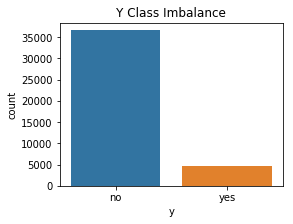

In [13]:
print("High class imbalance:\n")
fig, ax = plt.subplots(figsize=(4,3))
sns.countplot(x="y", data=df)
plt.title('Y Class Imbalance')
plt.show()

In [14]:
#passthrough = ['year', 'month', 'day']

In [15]:
#Models to be evaluated - can be modified/overridden to include more
def models():
    models = {}
    models['log'] = (LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=1), {'C':[0.01, 0.1, 1]})
    models['ridge'] = (RidgeClassifier(class_weight='balanced', random_state=1), {'alpha':[0.01, 0.1, 1]})
    #models['svc'] = (SVC(class_weight='balanced'), {'C':[0.1, 1], 'gamma':['auto']})
    models['ada'] = (AdaBoostClassifier(random_state=1), {'learning_rate':[0.5, 1]})
    models['gbm'] = (GradientBoostingClassifier(random_state=1), {'learning_rate':[0.5, 1]})
    #models['gaus_nb'] = (GaussianNB(), {'var_smoothing':[1e-9, 1]})
    
    models['bagging_class'] = (BaggingClassifier(random_state=1), {'n_estimators':[7,12], 'max_samples':[1,5]})
    models['rf_class'] = (RandomForestClassifier(class_weight='balanced', random_state=1), {'max_depth':[100, 1000], 'max_leaf_nodes':[10, 20, 30]})
    
    return models

In [16]:
#Split data between training and test sets
def split_data(df, target_name, test_size):

    X = df.drop(str(target_name), axis=1)
    y = df[str(target_name)]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state = 1)

    return X_train, X_test, y_train, y_test

In [17]:
def processing_pipeline(numeric_features, categorical_features, bin_features, lab_bin_features, classifier):

    #numeric_features and categorical_features must be lists

    numeric_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    binary_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('binary', Binarizer())])
    
    label_binary_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('label_binary', OneHotEncoder(sparse=False))])
    
    #intact_transformer = Pipeline(steps=[
    #    ('intact', )
    #])

    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('bin', binary_transformer, bin_features), 
        ('lab_bin', label_binary_transformer, lab_bin_features) 
    ], 
        #setting remainder to passthrough so features that are not included are not dropped
        remainder='passthrough')

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('clf', classifier)])

    return pipe

In [18]:
#Evaluate classifiers:
def evaluate_classifier(X_train, X_test, y_train, y_test, pipe, classifier_paramgrid, metric):

    #NB: classifier_paramgrid should be a tuple with the classifier and its associated param grid for GridsearchCV

    classifier, param_grid = classifier_paramgrid[0], classifier_paramgrid[1]

    new_param_grid = {}
    for i,k in param_grid.items():
        j = 'clf__'+i
        new_param_grid[j] = k

    #Using stratified kfold to address imbalanced classes in target feature:
    cv = StratifiedKFold(n_splits=5, random_state=1)
    
    #Customization for timeseries: using TimeSeriesSplit
    #cv = TimeSeriesSplit(n_splits=2)

    gs = GridSearchCV(estimator=pipe, param_grid=[new_param_grid], n_jobs=-1, cv=cv, scoring=metric)

    gs.fit(X_train, y_train)

    cv_metric = cross_val_score(gs, X_train, y_train, cv=cv)

    print("\n---------")
    print("Model Evaluated: ", gs.best_estimator_.named_steps['clf'])
    print("Training {} Mean with CV: {}".format(metric, cv_metric.mean()))
    print("Training {} Standard Dev with CV: {}".format(metric, cv_metric.std()))
    print("Test Score: %.3f" % gs.score(X_test, y_test))

    return cv_metric

In [19]:
#Main function to execute the workflow
def execute_spotcheck(df, target_name, test_size, numeric_features, categorical_features, bin_features, lab_bin_features):

    #Split the data so to leave a final test set to avoid data leakage
    X_train, X_test, y_train, y_test = split_data(df, target_name, test_size)

    #Create a dictionary holding models that will be evaluated
    models_tested = models()

    model_results = {}

    for k, (model, params) in models_tested.items():
        #Create pipeline to apply the same transformations to each model evaluated
        pipe = processing_pipeline(numeric_features, categorical_features, bin_features, lab_bin_features, model)
        cv_metric = evaluate_classifier(X_train, X_test, y_train, y_test, pipe, (model, params), 'accuracy')
        model_results[k] = cv_metric

    return model_results, models_tested

In [20]:
#Simple visualization of outcomes:
def visualize_results(model_results, models_tested):
    
    models_report = pd.DataFrame(model_results, columns=list(models_tested.keys()))
    
    fig, ax1 = plt.subplots(figsize=(len(models_report.columns)*3,4))
    sns.boxplot(data=models_report, ax=ax1)
    plt.suptitle('Model Evaluation Report')
    plt.show()

In [21]:
model_results, models_tested = execute_spotcheck(df, 'y', 0.2, numeric_features, categorical_features, binary_features, label_binary)


---------
Model Evaluated:  LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
Training accuracy Mean with CV: 0.8309864749486247
Training accuracy Standard Dev with CV: 0.0025438435467159516
Test Score: 0.835

---------
Model Evaluated:  RidgeClassifier(alpha=1, class_weight='balanced', copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False, random_state=1,
        solver='auto', tol=0.001)
Training accuracy Mean with CV: 0.8277087860531191
Training accuracy Standard Dev with CV: 0.002795631088388556
Test Score: 0.832

---------
Model Evaluated:  AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=50, random_state=1)
Training accuracy Mean with CV: 0.9000303020478478
Training accuracy Standard Dev with CV:

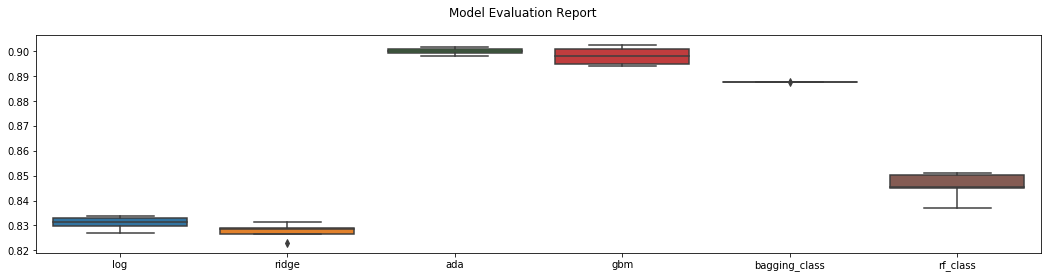

In [22]:
visualize_results(model_results, models_tested)

Adaboost, Gradient Boosted Machine and the Bagging Classifier (unsurprisingly) show better results as they are different variations of ensembles that employ resampling strategies and thus tend to do well with imbalanced classes such as in this case. Next, we will analyze bias-complexity errors, confusion matrices, and try to pick one model to explore further refinement options such as feature engineering.

Notice we haven't conducted a fully exhaustive hyperparameter search yet so these results are not final, however they give us a good idea for what could have promising results. Furthermore, we will have the option to later search hyperparameters that yield better recall or precision rather than using accuracy as done so far.

In [23]:
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ClassificationReport, PrecisionRecallCurve, ConfusionMatrix

In [24]:
cv = StratifiedKFold(5)
sizes = np.linspace(0.3, 1.0, 10)

In [25]:
#run this just once:
df_eval = df.copy()
y = df_eval.y
y = [1 if i == 'yes' else 0 for i in df_eval.y]
df_eval.drop('y', axis=1, inplace=True)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df_eval, y, test_size=0.2, random_state = 1)

Recreating the three classifiers with their best hyperparameters

In [28]:
best_ada = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=50, random_state=1)

In [29]:
pipe_ada = processing_pipeline(numeric_features, categorical_features, binary_features, label_binary, best_ada)

In [30]:
best_gbm = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=1,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [31]:
pipe_gbm = processing_pipeline(numeric_features, categorical_features, binary_features, label_binary, best_gbm)

In [32]:
best_bg = BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1,
         n_estimators=7, n_jobs=None, oob_score=False, random_state=1,
         verbose=0, warm_start=False)

In [33]:
pipe_bg = processing_pipeline(numeric_features, categorical_features, binary_features, label_binary, best_bg)

Visualizing Model Results

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


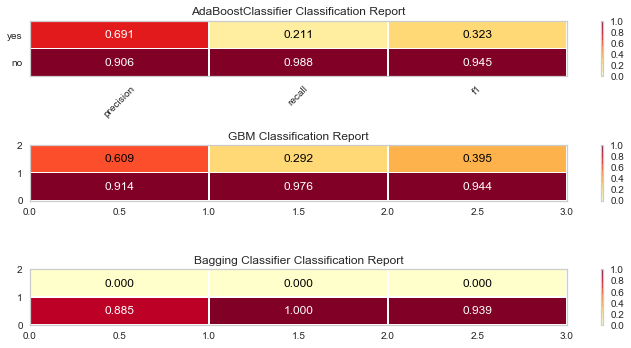

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

In [50]:
fig, axes = plt.subplots(3,1,figsize=(10,5))

cr_ada = ClassificationReport(pipe_ada, ax=axes[0], classes=['no', 'yes'])
cr_ada.fit(X_train, y_train)
cr_ada.score(X_test, y_test)

cr_gbm = ClassificationReport(pipe_gbm, ax=axes[1], classes=['no', 'yes'])
cr_gbm.fit(X_train, y_train)
cr_gbm.score(X_test, y_test)

cr_bg = ClassificationReport(pipe_bg, ax=axes[2], classes=['no', 'yes'])
cr_bg.fit(X_train, y_train)
cr_bg.score(X_test, y_test)

axes[1].set(title='GBM Classification Report')
axes[2].set(title='Bagging Classifier Classification Report')

cr_ada.poof()
cr_gbm.poof()
cr_bg.poof()

Learning curves are showing some variance for Ridge Classifier. Let's look at RandomForestClassifier next

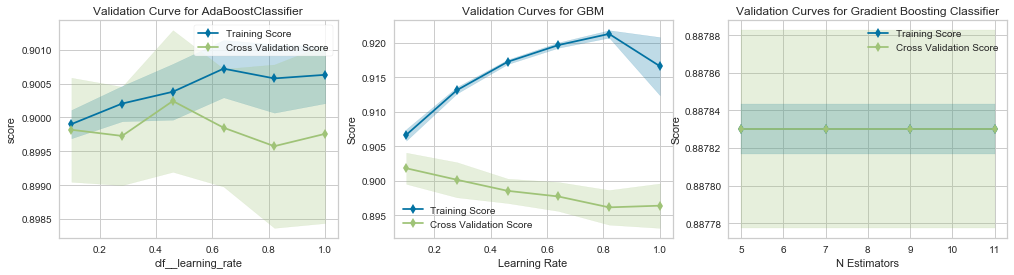

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17,4))

viz_vc_ada = ValidationCurve(
    pipe_ada, param_name="clf__learning_rate",
    param_range=np.linspace(0.1,1, 6), cv=cv, scoring="accuracy", ax=axes[0])

viz_vc_ada.fit(X_train, y_train)

viz_vc_gbm = ValidationCurve(
    pipe_gbm, param_name="clf__learning_rate",
    param_range=np.linspace(0.1,1, 6), cv=cv, scoring="accuracy", ax=axes[1])

viz_vc_gbm.fit(X_train, y_train)

viz_vc_bg = ValidationCurve(
    pipe_bg, param_name="clf__n_estimators",
    param_range=[5,7,9,11], cv=cv, scoring="accuracy", ax=axes[2])

viz_vc_bg.fit(X_train, y_train)

axes[1].set(title='Validation Curves for GBM', xlabel='Learning Rate', ylabel='Score')
axes[2].set(title='Validation Curves for Gradient Boosting Classifier', xlabel='N Estimators', ylabel='Score')
axes[1].legend().set_visible(True)
axes[2].legend().set_visible(True)

viz_vc_ada.poof()
viz_vc_gbm.poof()
viz_vc_bg.poof()

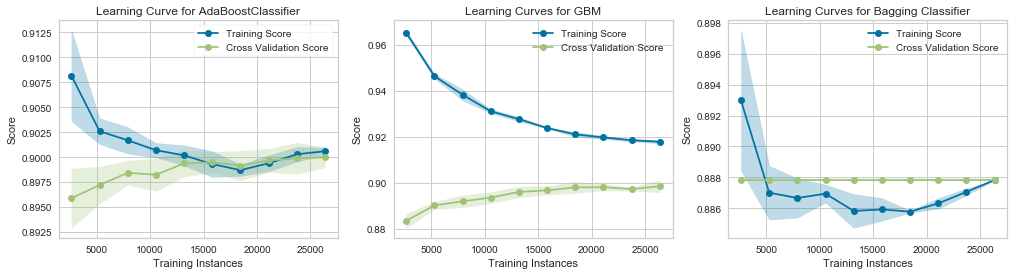

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17,4))

viz_lc_ada = LearningCurve(
    pipe_ada, train_sizes = np.linspace(0.1, 1.0, 10), cv=cv, ax=axes[0]
)
# Fit and poof the visualizer
viz_lc_ada.fit(X_train, y_train)

viz_lc_gbm = LearningCurve(
    pipe_gbm, train_sizes = np.linspace(0.1, 1.0, 10), cv=cv, ax=axes[1]
)
# Fit and poof the visualizer
viz_lc_gbm.fit(X_train, y_train)

viz_lc_bg = LearningCurve(
    pipe_bg, train_sizes = np.linspace(0.1, 1.0, 10), cv=cv, ax=axes[2]
)
# Fit and poof the visualizer
viz_lc_bg.fit(X_train, y_train)

axes[1].set(title='Learning Curves for GBM', xlabel='Training Instances', ylabel='Score')
axes[2].set(title='Learning Curves for Bagging Classifier', xlabel='Training Instances', ylabel='Score')
axes[1].legend().set_visible(True)
axes[2].legend().set_visible(True)

viz_lc_ada.poof()
viz_lc_gbm.poof()
viz_lc_bg.poof()

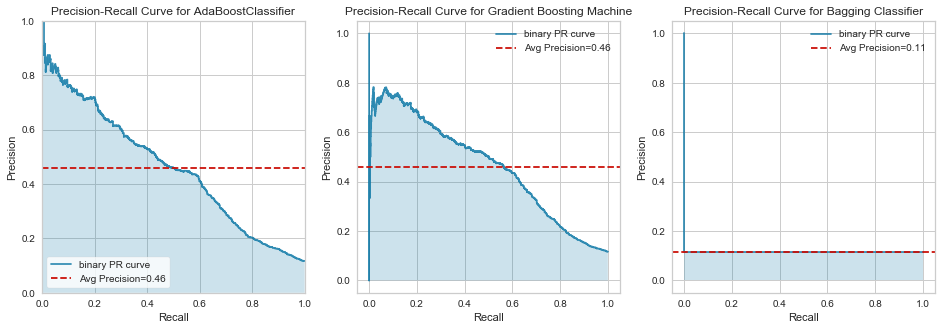

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(16,5))

viz_pc_ada = PrecisionRecallCurve(pipe_ada, ax=axes[0])
viz_pc_ada.fit(X_train, y_train)
viz_pc_ada.score(X_test, y_test)

viz_pc_gbm = PrecisionRecallCurve(pipe_gbm, ax=axes[1])
viz_pc_gbm.fit(X_train, y_train)
viz_pc_gbm.score(X_test, y_test)

viz_pc_bg = PrecisionRecallCurve(pipe_bg, ax=axes[2])
viz_pc_bg.fit(X_train, y_train)
viz_pc_bg.score(X_test, y_test)

axes[1].set(title='Precision-Recall Curve for Gradient Boosting Machine', xlabel='Recall', ylabel='Precision')
axes[2].set(title='Precision-Recall Curve for Bagging Classifier', xlabel='Recall', ylabel='Precision')
axes[1].legend().set_visible(True)
axes[2].legend().set_visible(True)

viz_pc_ada.poof()
viz_pc_gbm.poof()
viz_pc_bg.poof()

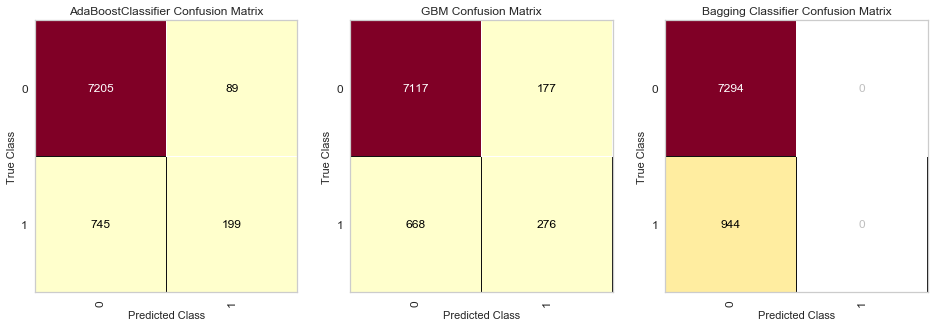

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(16,5))

cm_ada = ConfusionMatrix(pipe_ada, classes=[0,1], ax=axes[0])
cm_ada.fit(X_train, y_train)
cm_ada.score(X_test, y_test)

cm_gbm = ConfusionMatrix(pipe_gbm, classes=[0,1], ax=axes[1])
cm_gbm.fit(X_train, y_train)
cm_gbm.score(X_test, y_test)

cm_bg = ConfusionMatrix(pipe_bg, classes=[0,1], ax=axes[2])
cm_bg.fit(X_train, y_train)
cm_bg.score(X_test, y_test)

axes[1].set(title='GBM Confusion Matrix', xlabel='Predicted Class', ylabel='True Class')
axes[2].set(title='Bagging Classifier Confusion Matrix', xlabel='Predicted Class', ylabel='True Class')

cm_ada.poof()
cm_gbm.poof()
cm_bg.poof()

The Gradient Boosted Classifier is showing great results. Let's try to improve them with new features. Notice that the features chosen for this dataset were already evaluated and selected from a wider domain: https://archive.ics.uci.edu/ml/datasets/bank+marketing 

Feature Engineering

We start with Recursive Feature Elimination to obtain an estimate of feature importances

In [94]:
#Current feature importances for the GBM model:
pipe_gbm.named_steps['clf'].feature_importances_

array([4.67681297e-02, 1.70491973e-02, 2.37123035e-02, 1.54520034e-02,
       2.74005380e-02, 9.49033292e-03, 5.07718365e-02, 7.75962173e-02,
       4.41023970e-01, 4.91130027e-03, 1.54254270e-02, 4.58940130e-02,
       6.31764002e-03, 0.00000000e+00, 8.06258000e-02, 7.32759068e-04,
       1.34065988e-03, 7.59211617e-04, 1.86371593e-04, 1.09994092e-03,
       1.90795718e-03, 2.49191108e-03, 2.90846477e-03, 2.60025707e-03,
       4.98067924e-03, 2.32875375e-03, 3.45750228e-03, 1.34410918e-03,
       0.00000000e+00, 4.41617237e-04, 1.26685865e-03, 1.18141609e-03,
       2.62022163e-03, 2.85126530e-03, 7.29606779e-04, 1.00713113e-04,
       3.51567034e-03, 3.59789722e-03, 5.59984061e-03, 3.92919533e-03,
       2.85891511e-04, 0.00000000e+00, 1.53026880e-03, 0.00000000e+00,
       1.72698694e-03, 1.13850623e-03, 1.18467729e-03, 3.06229301e-03,
       1.78715998e-03, 5.81839517e-04, 8.01513873e-05, 1.69140806e-03,
       1.65227460e-03, 4.02272737e-04, 2.17203184e-03, 2.75226774e-03,
      

Currently in Sklearn there is no way to use the get_feature_names() function on a Pipeline object. We will create some new features and include a feature elimination step in our pipeline object to eliminate unnecessary features. 

In [ ]:
#Creating some new categorical features with binning:
df['age_bin'] = pd.cut(df['age'], 4, labels = [0,1,2,3])
#create new flag with number of days since, is new lead, etc.

Step 1: understand what currently are the features most correlated with y

In [128]:
df.dtypes

year                          int64
month                         int64
day                           int64
age                           int64
job                          object
marital                      object
education                    object
default                      object
housing                      object
loan                         object
contact                      object
month_last_contact           object
day_of_week_last_contact     object
campaign                      int64
pdays                         int64
previous                      int64
poutcome                     object
emp.var.rate                float64
cons.price.idx              float64
cons.conf.idx               float64
euribor3m                   float64
nr.employed                 float64
y                            object
weekday                       int64
month_total_days              int64
is_holiday                    int64
holiday_name                 object
biz_payday                  

In [162]:
cols = binary_features+ categorical_features

In [163]:
cols.remove('year')

In [164]:
cols.append('contact')

In [165]:
df_corr = pd.get_dummies(df, columns=cols)

In [166]:
df_corr['y'] = [1 if i == 'yes' else 0 for i in df.y]

In [167]:
df_corr.reset_index(inplace=True)
df_corr.drop('Date', axis=1, inplace=True)

In [173]:
from scipy import stats
import math
#Correlation between independent features and (binary) target var
pbcorr_list = []
for i in df_corr.columns:
    if math.isnan(stats.pointbiserialr(df_corr[i],df_corr['y'])[0]) != True:
        pbcorr_list.append((str(i), stats.pointbiserialr(df_corr[i],df_corr['y'])[0]))

In [185]:
list(filter(lambda x: x[1] < -.1, pbcorr_list)) + list(filter(lambda x: x[1] > .10, pbcorr_list)) 

[('pdays', -0.32491447761663333),
 ('emp.var.rate', -0.29833442615937855),
 ('cons.price.idx', -0.13621121281924775),
 ('euribor3m', -0.30777140394072106),
 ('nr.employed', -0.354678295921437),
 ('poutcome_nonexistent', -0.19350684552056135),
 ('month_last_contact_may', -0.10827118387516642),
 ('contact_telephone', -0.14477305571200072),
 ('year', 0.3478278344442572),
 ('previous', 0.23018100321659118),
 ('y', 1.0),
 ('poutcome_success', 0.31626938381981556),
 ('month_last_contact_mar', 0.14401401664144514),
 ('month_last_contact_oct', 0.13736593059421323),
 ('month_last_contact_sep', 0.12606735856323756),
 ('contact_cellular', 0.14477305571200072)]

In [ ]:
Based on the above, we will create some new categorical features by combining 

In [117]:
cols = ['job', 'marital', 'education', 'default', 'housing','loan', 'contact', 'age_bin']

In [118]:
import itertools
combos = []
for r in range(2,len(cols)):
    combos+= [i for i in list(itertools.combinations(cols, r))]

In [119]:
combos

[('job', 'marital'),
 ('job', 'education'),
 ('job', 'default'),
 ('job', 'housing'),
 ('job', 'loan'),
 ('job', 'contact'),
 ('job', 'age_bin'),
 ('marital', 'education'),
 ('marital', 'default'),
 ('marital', 'housing'),
 ('marital', 'loan'),
 ('marital', 'contact'),
 ('marital', 'age_bin'),
 ('education', 'default'),
 ('education', 'housing'),
 ('education', 'loan'),
 ('education', 'contact'),
 ('education', 'age_bin'),
 ('default', 'housing'),
 ('default', 'loan'),
 ('default', 'contact'),
 ('default', 'age_bin'),
 ('housing', 'loan'),
 ('housing', 'contact'),
 ('housing', 'age_bin'),
 ('loan', 'contact'),
 ('loan', 'age_bin'),
 ('contact', 'age_bin'),
 ('job', 'marital', 'education'),
 ('job', 'marital', 'default'),
 ('job', 'marital', 'housing'),
 ('job', 'marital', 'loan'),
 ('job', 'marital', 'contact'),
 ('job', 'marital', 'age_bin'),
 ('job', 'education', 'default'),
 ('job', 'education', 'housing'),
 ('job', 'education', 'loan'),
 ('job', 'education', 'contact'),
 ('job', 'e

In [ ]:
def create_cat_features(df, combos, pred_var, operation):
    
    if operation == 'sum':
    
        for combo in combos:
            df_temp = df[list(combo) + [pred_var]].groupby(list(combo)).sum().reset_index(drop=0)
            combo_name = pred_var +'-'+'-'.join(combo)+'-categorical'
            df_temp.rename(columns = {pred_var:combo_name}, inplace=True)
            df = df.merge(df_temp, how='left', on=list(combo))
    
    elif operation == 'avg':
        
        for combo in combos:
            df_temp = df[list(combo) + [pred_var]].groupby(list(combo)).mean().reset_index(drop=0)
            combo_name = pred_var +'-'+'-'.join(combo)+'-categorical'
            df_temp.rename(columns = {pred_var:combo_name}, inplace=True)
            df = df.merge(df_temp, how='left', on=list(combo))
    
    else:
        print("You have entered the wrong operation")
        print("Please enter sum or avg")
    
    return df

- create some new features
- try voting classifier or any custom ensemble?
- use imbalanced learning library 
- do feature importance and plot classifier comparisons with respect to the most important feature

In [103]:
from sklearn.pipeline import FeatureUnion

In [113]:
df_test = df[['job', 'age']]

Tune According to Campaign ROI as defined by differenced between avg loan and deposit interest rates and fixed/var campaign costs

In [42]:
clf = LogisticRegression(C=1, max_iter=100, class_weight = 'balanced')

In [43]:
clf.fit(X,y)

NameError: name 'X' is not defined

In [ ]:
y_pred = pipe.predict(df_eval)

In [ ]:
def make_conf_matrix(clf, X,y):
    y_pred = clf.predict(X)
    cmx = pd.DataFrame(confusion_matrix(y, y_pred), 
                   index = ['No', 'Yes'],
                   columns = ['No', 'Yes'])
    return cmx

In [ ]:
def plot_conf_matrix(cmx):
    cmap = mpl.colors.ListedColormap(['green'])
    cmap1 = mpl.colors.ListedColormap(['red'])
    mask1 = (cmx.isin([cmx.iloc[0,0],cmx.iloc[1,1]]))
    
    f, ax = plt.subplots(figsize = (9,6))
    sns.heatmap(cmx, annot=True, fmt = 'g', cmap = cmap,
            cbar = False, annot_kws={"size": 20},
            ax=ax)
    sns.heatmap(cmx, mask=mask1 , cmap=cmap1, cbar=False)

    ax.set_ylabel('True label', fontsize = 15)
    ax.set_xlabel('Predicted label', fontsize = 15)
    ax.set_title("Confusion Matrix", fontsize = 20)
    plt.show()

In [ ]:
#Creating Confusion Matrix for Dirty Model:
cmx = make_conf_matrix(pipe, df_eval, y)
plot_conf_matrix(cmx)

In [ ]:
print("Campaign Targets:", cmx.iloc[1,1]+cmx.iloc[0,1])

In [ ]:
accept_est = cmx.iloc[1,1]
reject_est = cmx.iloc[0,1]
total_targeted = accept_est+reject_est

In [ ]:
#enhancement: create rolling window logistic regression predicting next month's subscriptions

In [ ]:
Xex = df_eval[['year','month','age','job','marital']]

In [ ]:
Xex.head()

In [ ]:
Xex.reset_index(drop=0, inplace=True)

In [ ]:
y = y.reset_index(drop=1)

In [ ]:
clf = LogisticRegression(solver='sag')

In [ ]:
Xex.drop(columns='Date',inplace=True)

In [ ]:
clf.fit(Xex,y)

In [ ]:
clf.predict(np.array([1,2,3,1,1]).reshape(1,-1))

In [ ]:
#for each value in decision threshold range, 
    #create logistic regression
    #calculate profit for campaign with average CLV for next x months
#select the logistic regression yielding the highest ROI

Campaign ROI Calculation

In [ ]:
%store -r 'pred_clv'

In [ ]:
customers_monthly = df[['year','month','day']].groupby(by=['year','month']).count()
customers_monthly = customers_monthly.reset_index()
customers_monthly.rename(columns = {'day':'count'},inplace=True)
customers_monthly.head()

In [ ]:
customers_monthly['perc_of_total'] = customers_monthly['count']/customers_monthly['count'].sum()

In [ ]:
def calc_revenue(accept_est, pred_clv):
    return accept_est*pred_clv     

In [ ]:
#calculate revenue on a monthly basis comparing with predicted customer clv
#compare y with y pred and do a monthly classification matrix

In [ ]:
revenue_est = calc_revenue(customers_monthly['count'], pred_clv)

In [ ]:
revenue_est

In [ ]:
def calc_